In [8]:
using DataFrames, CSV, LinearAlgebra
using GLM, StatsModels, Plots

Trees = CSV.read("cherry-trees.csv", DataFrame)
fo = @formula(Volume ~ 1 + Girth)
A = modelmatrix(fo.rhs, Trees)    # the predictors
b = (modelmatrix(fo.lhs, Trees)) # the response

function huber(u, M=1)
    #returns Huberized residual
    if (abs(u) <= M)
        return u^2
    else
        return M*(2*abs(u) - M)
    end
end

huber (generic function with 2 methods)

In [9]:
#Function to be minimized
function h(x, M=1)
    hubers = 0
    for i in 1:size(A,1)
       hubers = hubers + huber(A[:, 2][i] * x[2] + x[1] - b[i], M)
    end
    return hubers
end

function ∇h1(x, M=1)
    #Gradient of the function
    grad = 0
    for i in 1:size(A,1)
        if (abs(A[:, 2][i] * x[2] + x[1] - b[i]) <= M)
            grad = grad + 2 * (A[:, 2][i] * x[2] + x[1] - b[i]) * A[i,1]
        else
            grad = grad + 2 * sign(A[:, 2][i] * x[2] + x[1] - b[i]) * M * A[i,1]
        end 
    end
    return grad
end

function ∇h2(x, M=1)
    #Gradient of the function
    grad = 0
    for i in 1:size(A,1)
        if (abs(A[:, 2][i] * x[2] + x[1] - b[i]) <= M)
            grad = grad + 2 * (A[:, 2][i] .* x[2] .+ x[1] .- b[i]) * A[:, 2][i]
        else
            grad = grad + 2 * A[:, 2][i] * M * sign(A[:, 2][i] * x[2] + x[1] - b[i])
        end 
    end
    return grad
end

function ∇h(x)
    return [∇h1(x), ∇h2(x)]
end

∇h (generic function with 1 method)

In [6]:
function wolfe(x,p)
    a = 1
    change = 0.75
    c = 0.0001
    d = 0.9
    while (h(x + a*p) > h(x) + c*a*transpose(p) * ∇h(x)) || (transpose(p) * ∇h(x + a*p) > d*transpose(p) * ∇h(x)) 
        #Sufficient decrease and curvature condition
        #println((h(x + a*p) > h(x) + c*a*transpose(p) * ∇h(x)), " + ", (transpose(p) * ∇h(x + a*p) > d*transpose(p) * ∇h(x)))
        a = change * a
    end
    return a
end

function steepest_descent(x; ϵ=1e-1, k=1000)
    i = 1
    while norm(∇h(x)) > ϵ
        p = -∇h(x)   # steepest descent direction
        α = wolfe(x,p)
        x[1] = x[1] + α*p[1]
        x[2] = x[2] + α*p[2]
        i % k == 0 && println("iteration ", i, ". x = ", x, " step ", α)
        i += 1
    end
    return x
end

steepest_descent (generic function with 1 method)

In [10]:
x = [1.0, 1.0]
p = -∇h(x)
#wolfe(x,p)
x_h = steepest_descent(x)

iteration 1000. x = [-24.276764364326752, 4.0150123219604605] step 0.00010045242572063329
iteration 2000. x = [-28.241149265536137, 4.360695163825451] step 0.00023810945356001964
iteration 3000. x = [-29.021479754421552, 4.420293370326095] step 3.178377532566912e-5


2-element Vector{Float64}:
 -29.09301160887012
   4.425490134645649

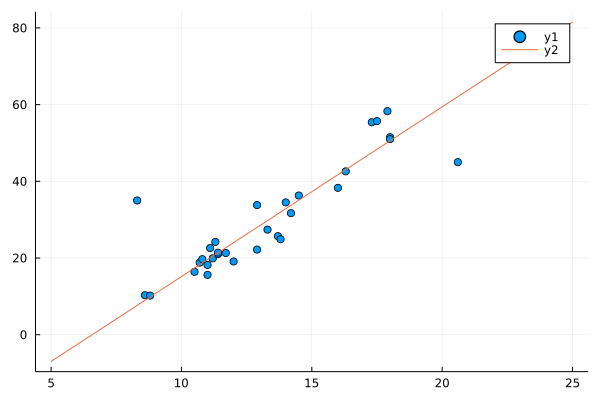

In [12]:
g(x) = x_h[2]*x+x_h[1]
x = range(5, 25, length=10000)
n = scatter(A[:,2],b)
plot(n)
plot!(x, g.(x))